In [1]:
from utils import *
from app import *

In [2]:
source, dest, lons, lats, dtime = get_directions('Holländische Reihe 15, Hamburg',
             'Bundesstrasse 53, Hamburg', 'cycling')

In [21]:
source, dest, lons, lats, dtime = get_directions('Holländische Reihe 15, Hamburg',
             'Bundesstrasse 53, Hamburg', 'cycling')
df = pd.DataFrame({'lons': lons, 
                               'lats': lats, 
                               'dtime': dtime.seconds.values,
                               'source': source,
                               'destination': dest})
out = df.to_json(date_format='iso', orient='split')

In [22]:
ds = pd.read_json(out, orient='split',)

In [23]:
ds

,lons,lats,dtime,source,destination
0,9.930301,53.547772,0,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
1,9.930545,53.547790,3,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
2,9.931742,53.547891,23,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
3,9.932055,53.547908,28,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
4,9.932257,53.547913,31,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
...,...,...,...,...,...
199,9.975916,53.567939,1539,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
200,9.975790,53.567913,1546,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
201,9.975353,53.567805,1575,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"
202,9.975388,53.567754,1580,"Holländische Reihe 15, 22765 Hamburg, Germany","Bundesstraße 53, 20146 Hamburg, Germany"


In [3]:
get_data(lons, lats, dtime)

,2020-11-09 19:50:00,2020-11-09 20:00:00,2020-11-09 20:10:00,2020-11-09 20:20:00,2020-11-09 20:30:00
0 days 00:01:12.900000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:01:01.800000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:05:12.900000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:11:07.500000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:18:19.900000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:21:24.500000,0.000104,0.000104,0.000104,0.000104,0.000104
0 days 00:25:30.300000,0.000104,0.000104,0.000104,0.000104,0.000104


In [5]:
df = utils.convert_to_dataframe(rain_bike,
                                    dtime_itinerary,
                                    time_radar)

In [8]:
df.rename(columns=lambda s: s.strftime('%H:%M'), 
                  index=lambda s: (s.seconds/60))

,19:40,19:50,20:00,20:10,20:20
1.200000,0.000104,0.000104,0.000104,0.000104,0.000104
1.016667,0.000104,0.000104,0.000104,0.000104,0.000104
5.200000,0.000104,0.000104,0.000104,0.000104,0.000104
11.116667,0.000104,0.000104,0.000104,0.000104,0.000104
18.316667,0.000104,0.000104,0.000104,0.000104,0.000104
21.400000,0.000104,0.000104,0.000104,0.000104,0.000104
25.500000,0.000104,0.000104,0.000104,0.000104,0.000104


In [336]:
def extract_rain_rate_from_radar_new(lon_bike, lat_bike, dtime_bike, 
                                 lon_radar, lat_radar, dtime_radar, rr):
    """
    Given the longitude, latitude and timedelta objects of the radar and of the bike iterate through 
    every point of the bike track and find closest point (in time/space) of the radar data. Then 
    construct the rain_bike array by subsetting the rr array, that is the data from the radar.

    Returns a numpy array with the rain forecast over the bike track.
    """
    from scipy.spatial import cKDTree
    combined_x_y_arrays = np.dstack([lon_radar.ravel(), lat_radar.ravel()])[0]
    points_list = list(np.vstack([lon_bike, lat_bike]).T)

    def do_kdtree(combined_x_y_arrays, points):
        mytree = cKDTree(combined_x_y_arrays)
        dist, indexes = mytree.query(points)
        return indexes

    results2 = do_kdtree(combined_x_y_arrays, points_list)
    # As we have many duplicates since the itinerary has a much higher resolution that then radar
    # we only select the unique points 
    inds_itinerary = np.unique(results2)
    lon_lat_itinerary = combined_x_y_arrays[inds_itinerary]
    
    # Now find the closest points in the bike track 
    combined_x_y_arrays = np.vstack([lon_bike, lat_bike]).T
    points_list = list(lon_lat_itinerary)

    results3 = do_kdtree(combined_x_y_arrays, points_list)
    dtime_itinerary = dtime_bike[results3]
    # find indices of these dtimes in radar dtime 
    inds_dtime_radar = np.abs(np.subtract.outer(dtime_radar, dtime_itinerary)).argmin(0)
    
    rain_bike = np.empty(shape=(len(shifts), len(inds_itinerary)))

    for i, shift in enumerate(shifts):
        temp = []
        for i_time, i_space in zip(inds_dtime_radar, inds_itinerary):
            temp.append(rr[i_time].ravel()[i_space])
        rain_bike[i, :] = temp

    rain_bike = ((10. ** ((rain_bike/2. - 32.5) / 10.)) / 256.) ** (1. / 1.42)

    return rain_bike

In [341]:
extract_rain_rate_from_radar_new(lons, lats, dtime, lon_radar, lat_radar, dtime_radar, rr)

array([[0.00010359, 0.00010359, 0.00010359, 0.00010359, 0.00010359,
        0.00010359, 0.00010359],
       [0.00010359, 0.00010359, 0.00010359, 0.00010359, 0.00010359,
        0.00010359, 0.00010359],
       [0.00010359, 0.00010359, 0.00010359, 0.00010359, 0.00010359,
        0.00010359, 0.00010359],
       [0.00010359, 0.00010359, 0.00010359, 0.00010359, 0.00010359,
        0.00010359, 0.00010359],
       [0.00010359, 0.00010359, 0.00010359, 0.00010359, 0.00010359,
        0.00010359, 0.00010359]])

In [338]:
extract_rain_rate_from_radar(lons, lats, dtime, lon_radar, lat_radar, dtime_radar, rr)

array([[0.00010359, 0.00010359, 0.00010359, ..., 0.00010359, 0.00010359,
        0.00010359],
       [0.00010359, 0.00010359, 0.00010359, ..., 0.00010359, 0.00010359,
        0.00010359],
       [0.00010359, 0.00010359, 0.00010359, ..., 0.00010359, 0.00010359,
        0.00010359],
       [0.00010359, 0.00010359, 0.00010359, ..., 0.00010359, 0.00010359,
        0.00010359],
       [0.00010359, 0.00010359, 0.00010359, ..., 0.00010359, 0.00010359,
        0.00010359]])

In [344]:
dtime_itinerary

TimedeltaIndex(['0 days 00:05:55.100000',        '0 days 00:08:04',
                '0 days 00:15:22.700000', '0 days 00:16:34.600000',
                       '0 days 00:22:10', '0 days 00:23:50.300000',
                '0 days 00:28:06.700000', '0 days 00:29:35.600000',
                '0 days 00:32:53.800000', '0 days 00:40:50.300000',
                '0 days 00:38:14.700000', '0 days 00:42:55.500000',
                '0 days 00:49:11.700000', '0 days 00:52:06.800000',
                '0 days 00:55:50.600000', '0 days 00:58:30.600000'],
               dtype='timedelta64[ns]', freq=None)

In [7]:
df = pd.DataFrame({'lons': lons, 
               'lats': lats, 
               'dtime': dtime.seconds.values,
               'source':source,
              'destination': dest})

In [290]:
proj_defs = {
    'euratl':
    {
        'extents':[-23.5, 45, 29.5, 70.5],
        'resolution': '50m',
        'regions':False
    },
    'it':
    {
        'extents':[6, 19, 36, 48],
        'resolution': '10m',
        'regions':True
    },
    'de':
    {
        'extents':[5, 16, 46.5, 56],
        'resolution': '10m',
        'regions':True
    },
        'ham':
    {
        'extents':[9.65, 10.5, 53, 54],
        'resolution': '10m',
        'regions':True
    }
}

In [230]:
import matplotlib.pyplot as plt

In [232]:
def get_projection_cartopy(plt, projection="euratl", compute_projection=False):
    '''Retrieve the projection using cartopy'''
    if compute_projection:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        import cartopy.io.shapereader as shpreader

        proj_opts = proj_defs[projection]

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(proj_opts['extents'], ccrs.PlateCarree())
        ax.coastlines(resolution=proj_opts['resolution'])
        ax.add_feature(cfeature.BORDERS.with_scale(proj_opts['resolution']))

        if proj_opts['regions']:
            states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=proj_opts['resolution'],
                facecolor='none')
            ax.add_feature(states_provinces, edgecolor='black', alpha=.5)

        return(ax)
    else:
        return(add_background(plt, projection, image=projection+"_background.png"))

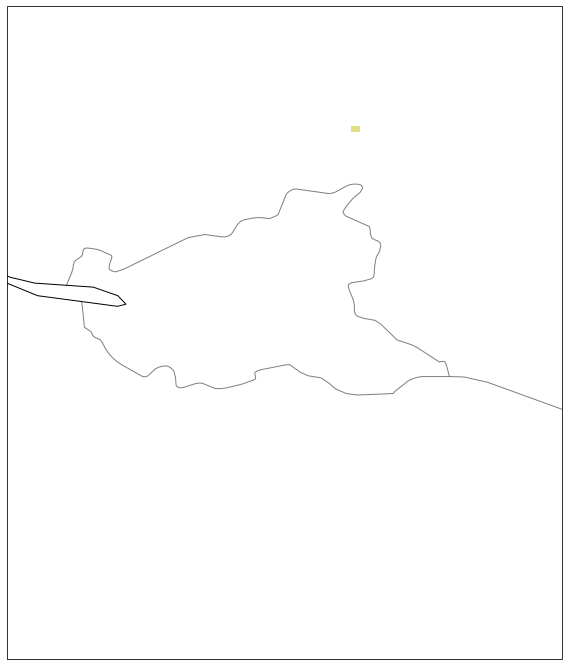

In [291]:
fig = plt.figure(figsize=(12, 12))

ax = get_projection_cartopy(plt, projection='ham', compute_projection=True)

ax.pcolormesh(lon_radar, lat_radar, rr[0], cmap='gist_stern_r')